This notebook is used to perform survival analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, plotting, CoxPHFitter

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : True,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 500,
})

%matplotlib inline

In [2]:
# Load the dataset and the extra data
df = pd.read_csv("./data/raw/data_cvd.csv", index_col=0, decimal='.')
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%Y/%m/%d")
df["Data prelievo"] = pd.to_datetime(df["Data prelievo"], format="%Y/%m/%d")

df_7y = pd.read_csv("./data/data.csv", index_col=0, decimal='.')
df = df.merge(df_7y.loc[:, ["Creatinina", "Survive7Y"]], how="left", left_index=True, right_index=True)

df["Death7Y"] = df["Survive7Y"].map(lambda x: (x+1)%2)

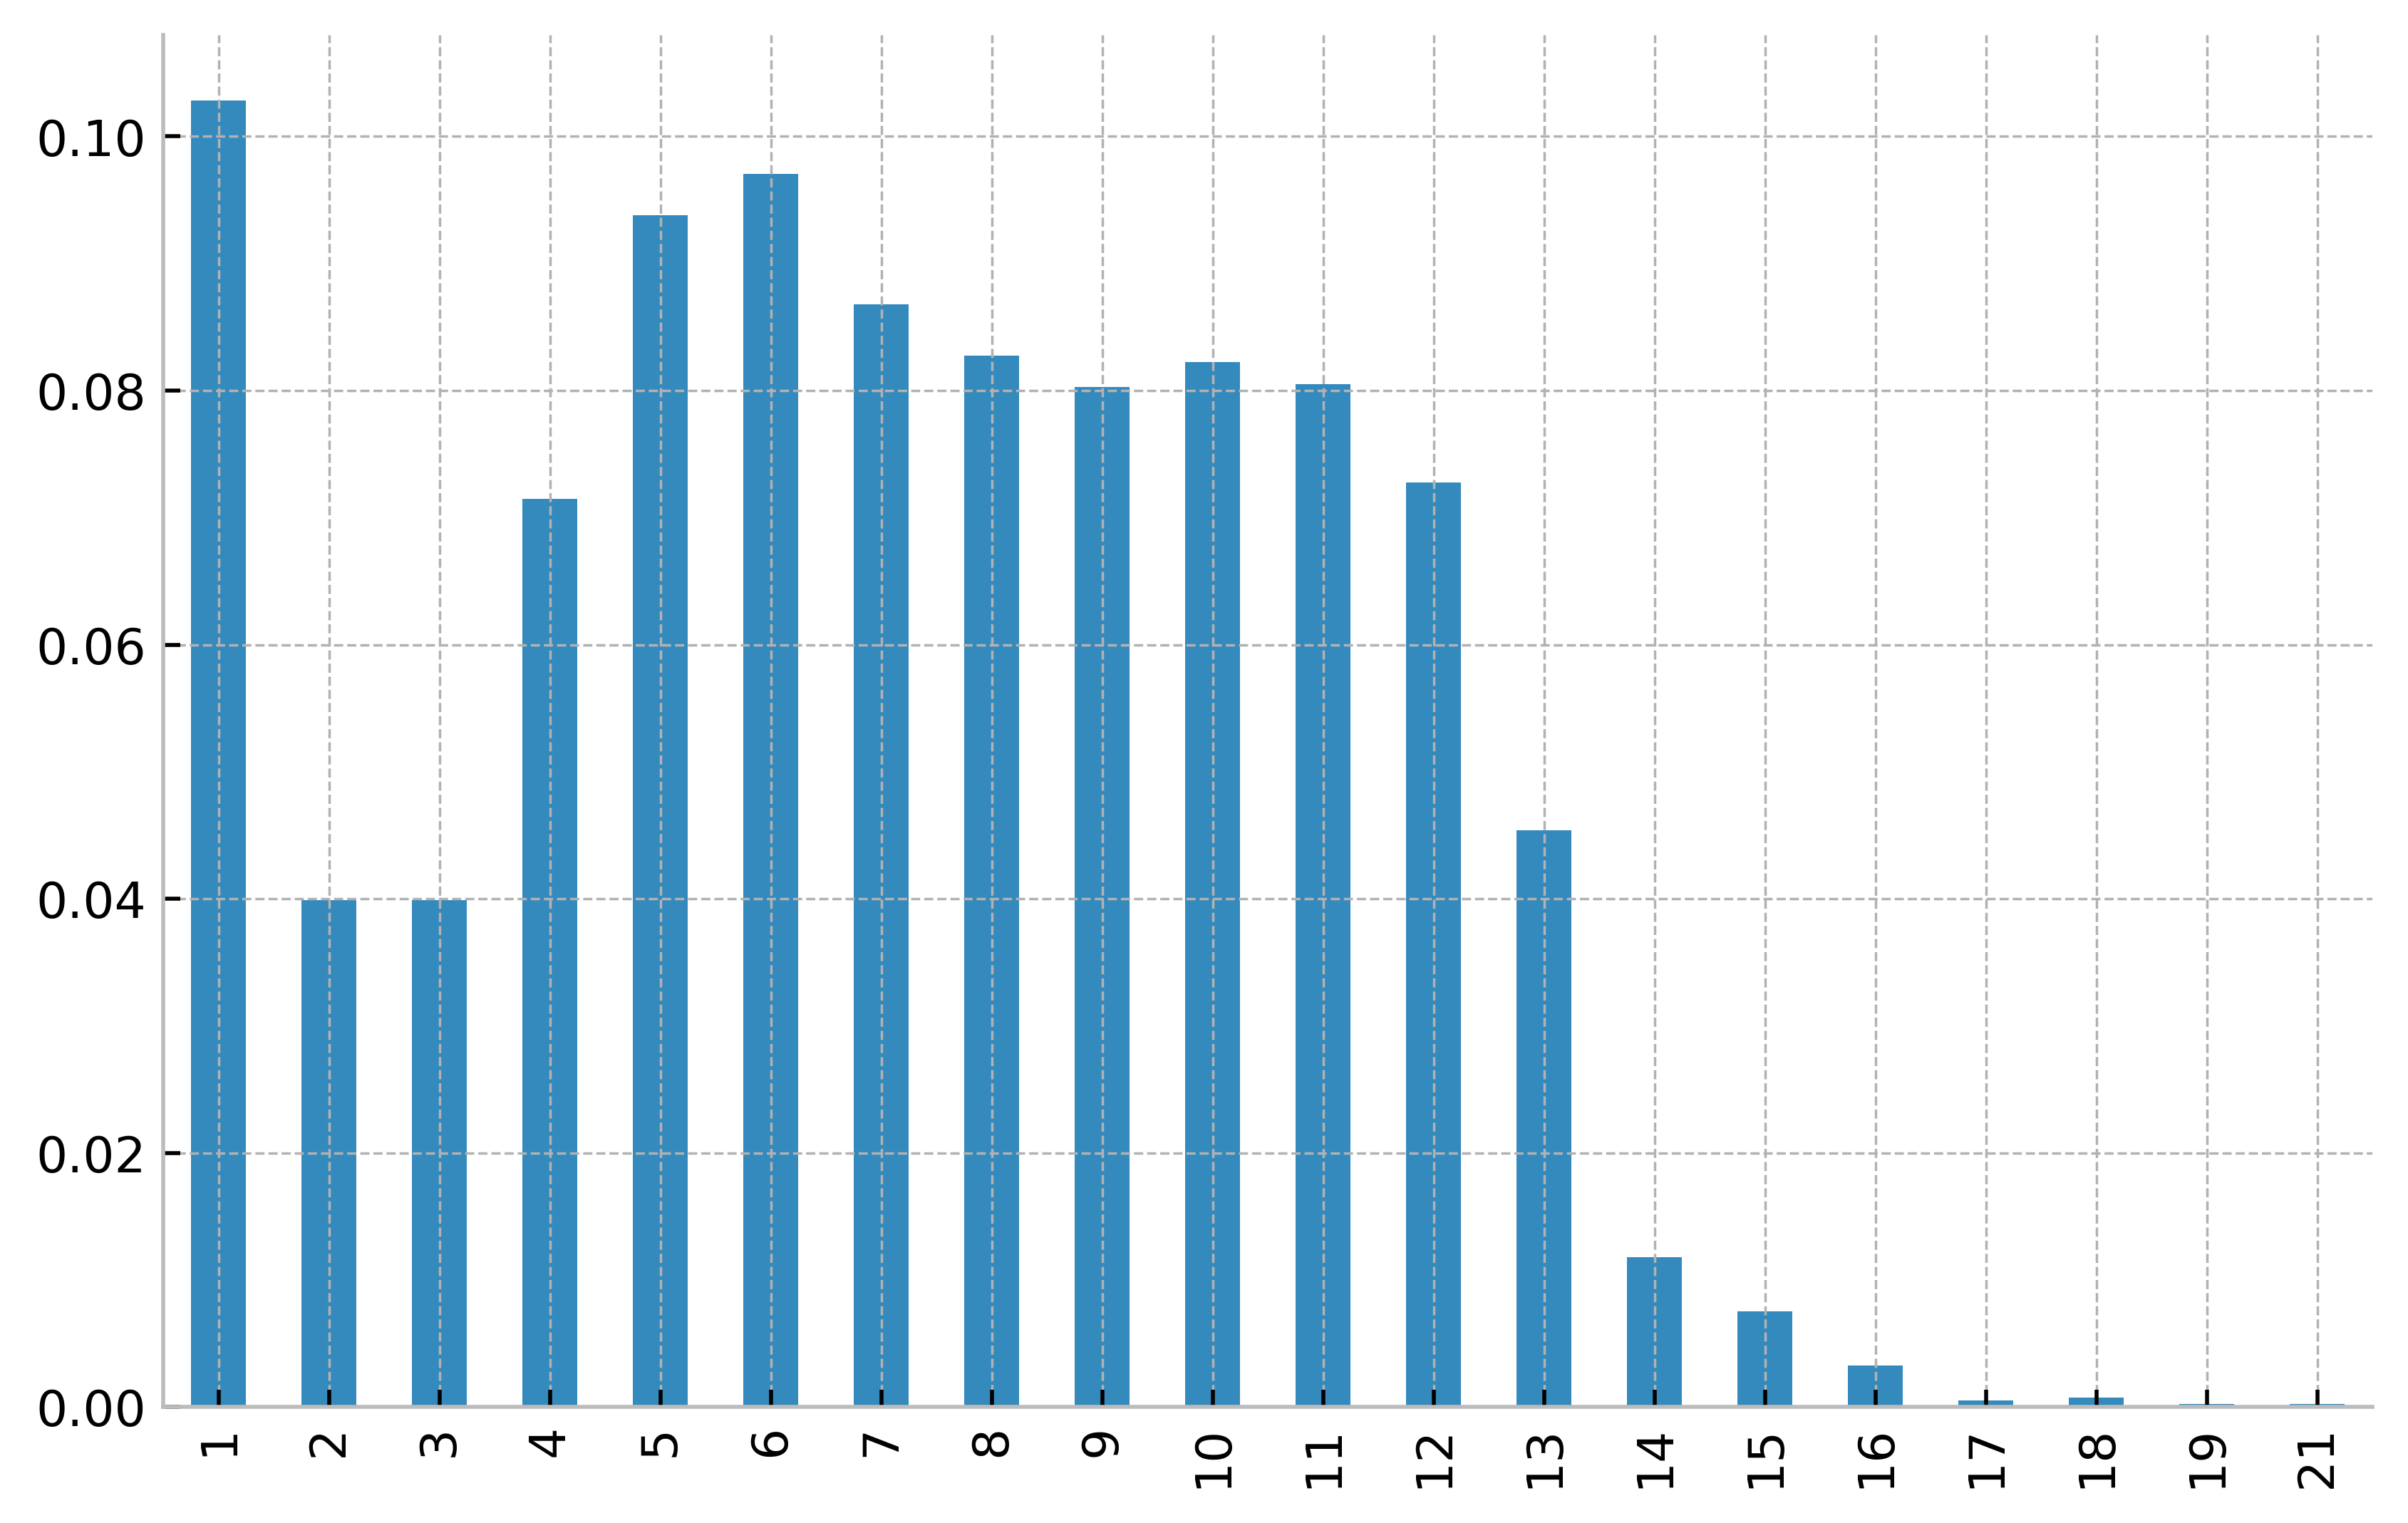

In [3]:
# Birth event: "Data prelievo"
# Death event: "Death7Y"
# Right-censoring occur if the patient is still alive at "Follow Up Data"

# Duration and observation features
df_surv = pd.DataFrame()
df_surv["Death7Y"] = df["Death7Y"]
df_surv["duration"] = (df["Follow Up Data"] - df["Data prelievo"]).map(lambda x: (x.days//365) + 1)
df_surv["observed"] = df["CVD Death"]
df_surv["ID"] = np.random.randint(0, 1e6, size=len(df_surv))

# Plot duration
df_surv["duration"].value_counts(normalize=True).sort_index().plot(kind='bar')
df_feat = pd.read_csv("./data/data.csv", index_col=0, decimal='.')
df_surv = df_feat.merge(df_surv, how="left", left_index=True, right_index=True)
# df_surv.to_csv("data/data_surv.csv")

### Survival Analysis on all the data
The plot indicates the % of CVD patients that survived after n years. For example, the probability for surviving more than 7 years is ~92%.

<AxesSubplot:title={'center':'Survival Function of CVD Patients (7 Years)'}, xlabel='Years', ylabel='Survive7Y'>

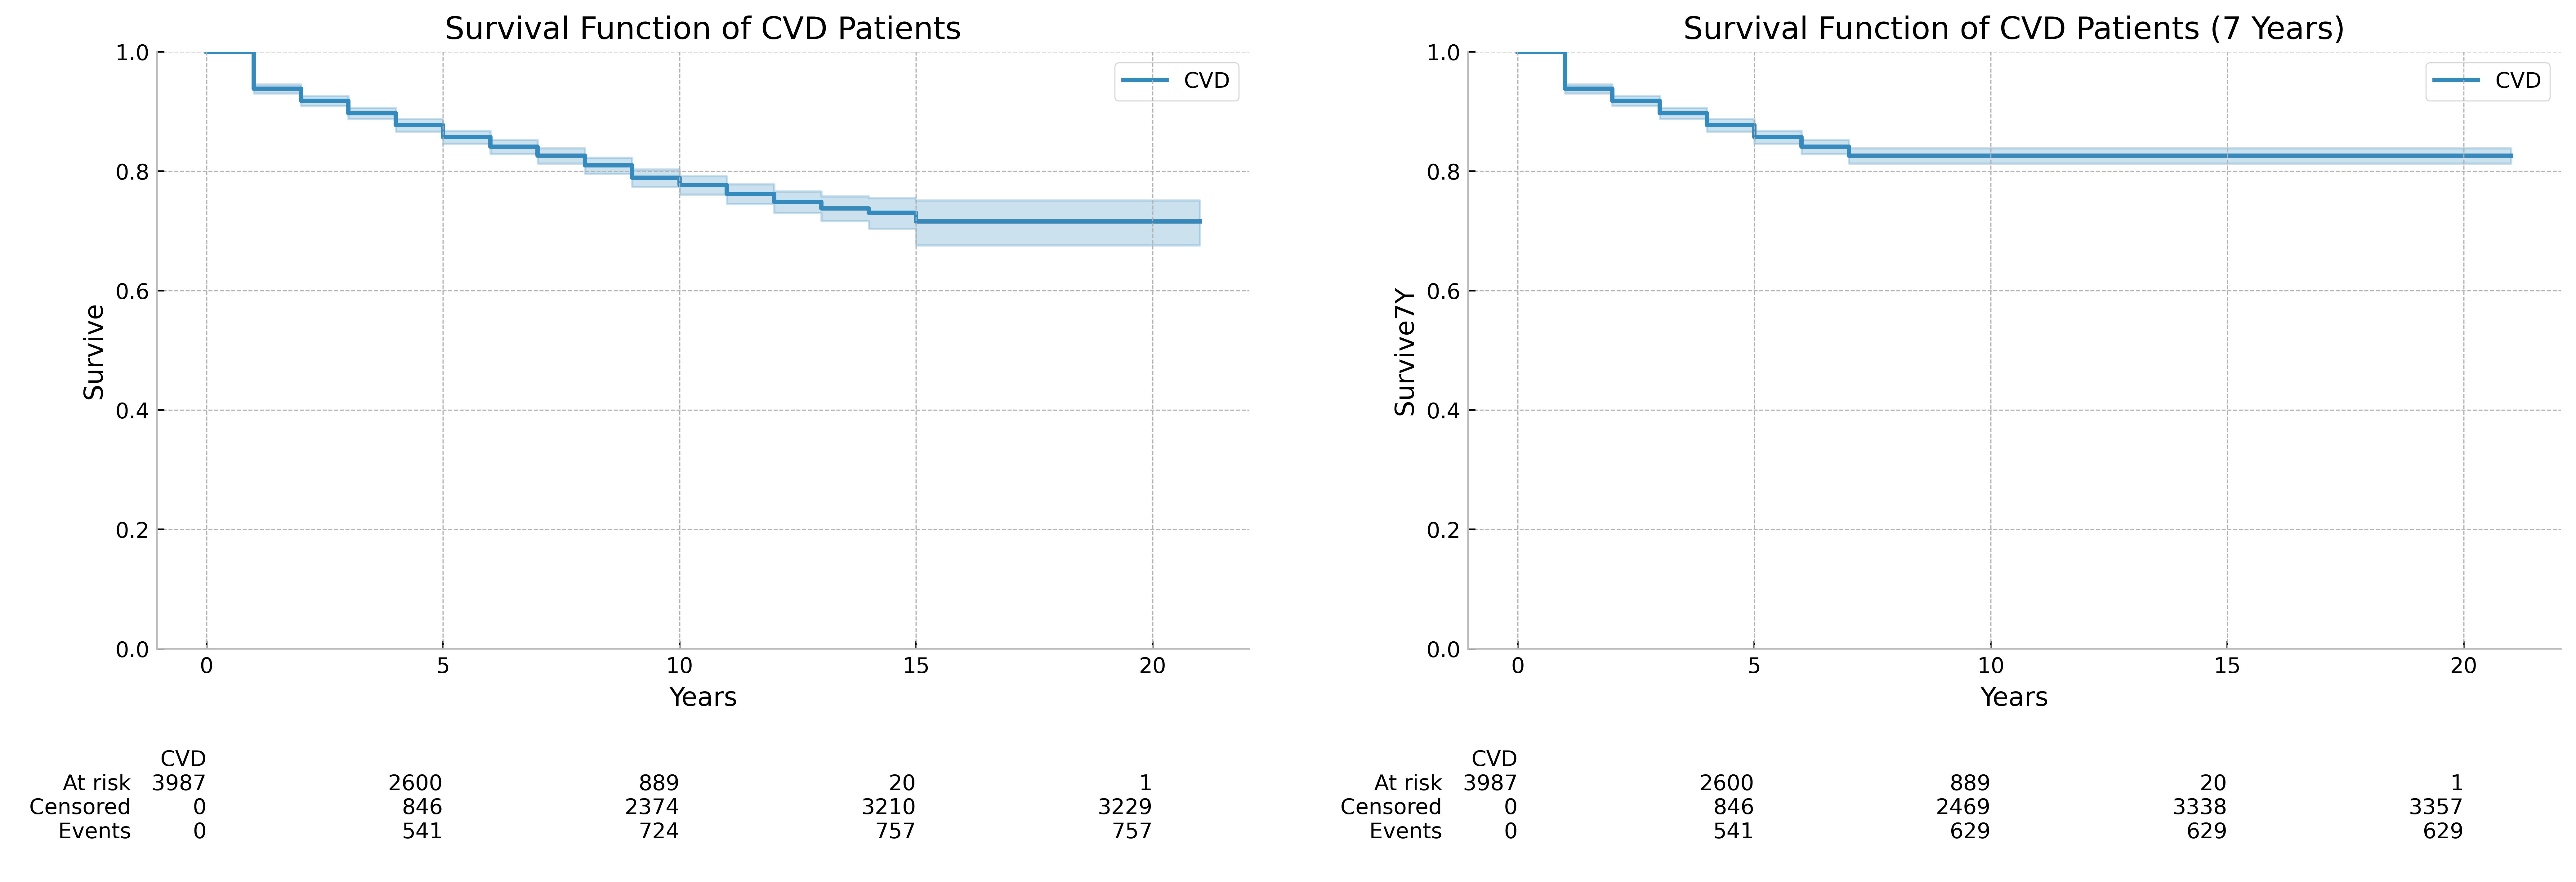

In [4]:
fig = plt.figure(figsize=(20, 5), dpi=500) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
kmf1 = KaplanMeierFitter()
kmf1.fit(df_surv["duration"], event_observed=df_surv["observed"], label="CVD")
kmf1.plot_survival_function()
plt.title('Survival Function of CVD Patients')
plt.xlabel("Years")
plt.ylabel("Survive")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1)

plt.subplot2grid(fig_dims, (0, 1))
kmf2 = KaplanMeierFitter()
kmf2.fit(df_surv["duration"], event_observed=df_surv["Death7Y"], label="CVD")
kmf2.plot_survival_function()
plt.title('Survival Function of CVD Patients (7 Years)')
plt.xlabel("Years")
plt.ylabel("Survive7Y")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf2)

# plt.savefig("")
# kmf.median_survival_time_
# kmf.confidence_interval_

### Survival Analysis Univariate

In [5]:
df_test = pd.read_csv("./data/test.csv", index_col=0, decimal='.').sort_index()
df_test = df_test.merge(df_surv.loc[:, ["duration", "observed"]], how="left", left_index=True, right_index=True)
df_test = df_test.rename(columns={"Hyperlipemia\nHistoty of hyperlipemia": "Dyslipidemia"})

<AxesSubplot:title={'center':'Survival Function of CAD Patients (Age)'}, xlabel='Years'>

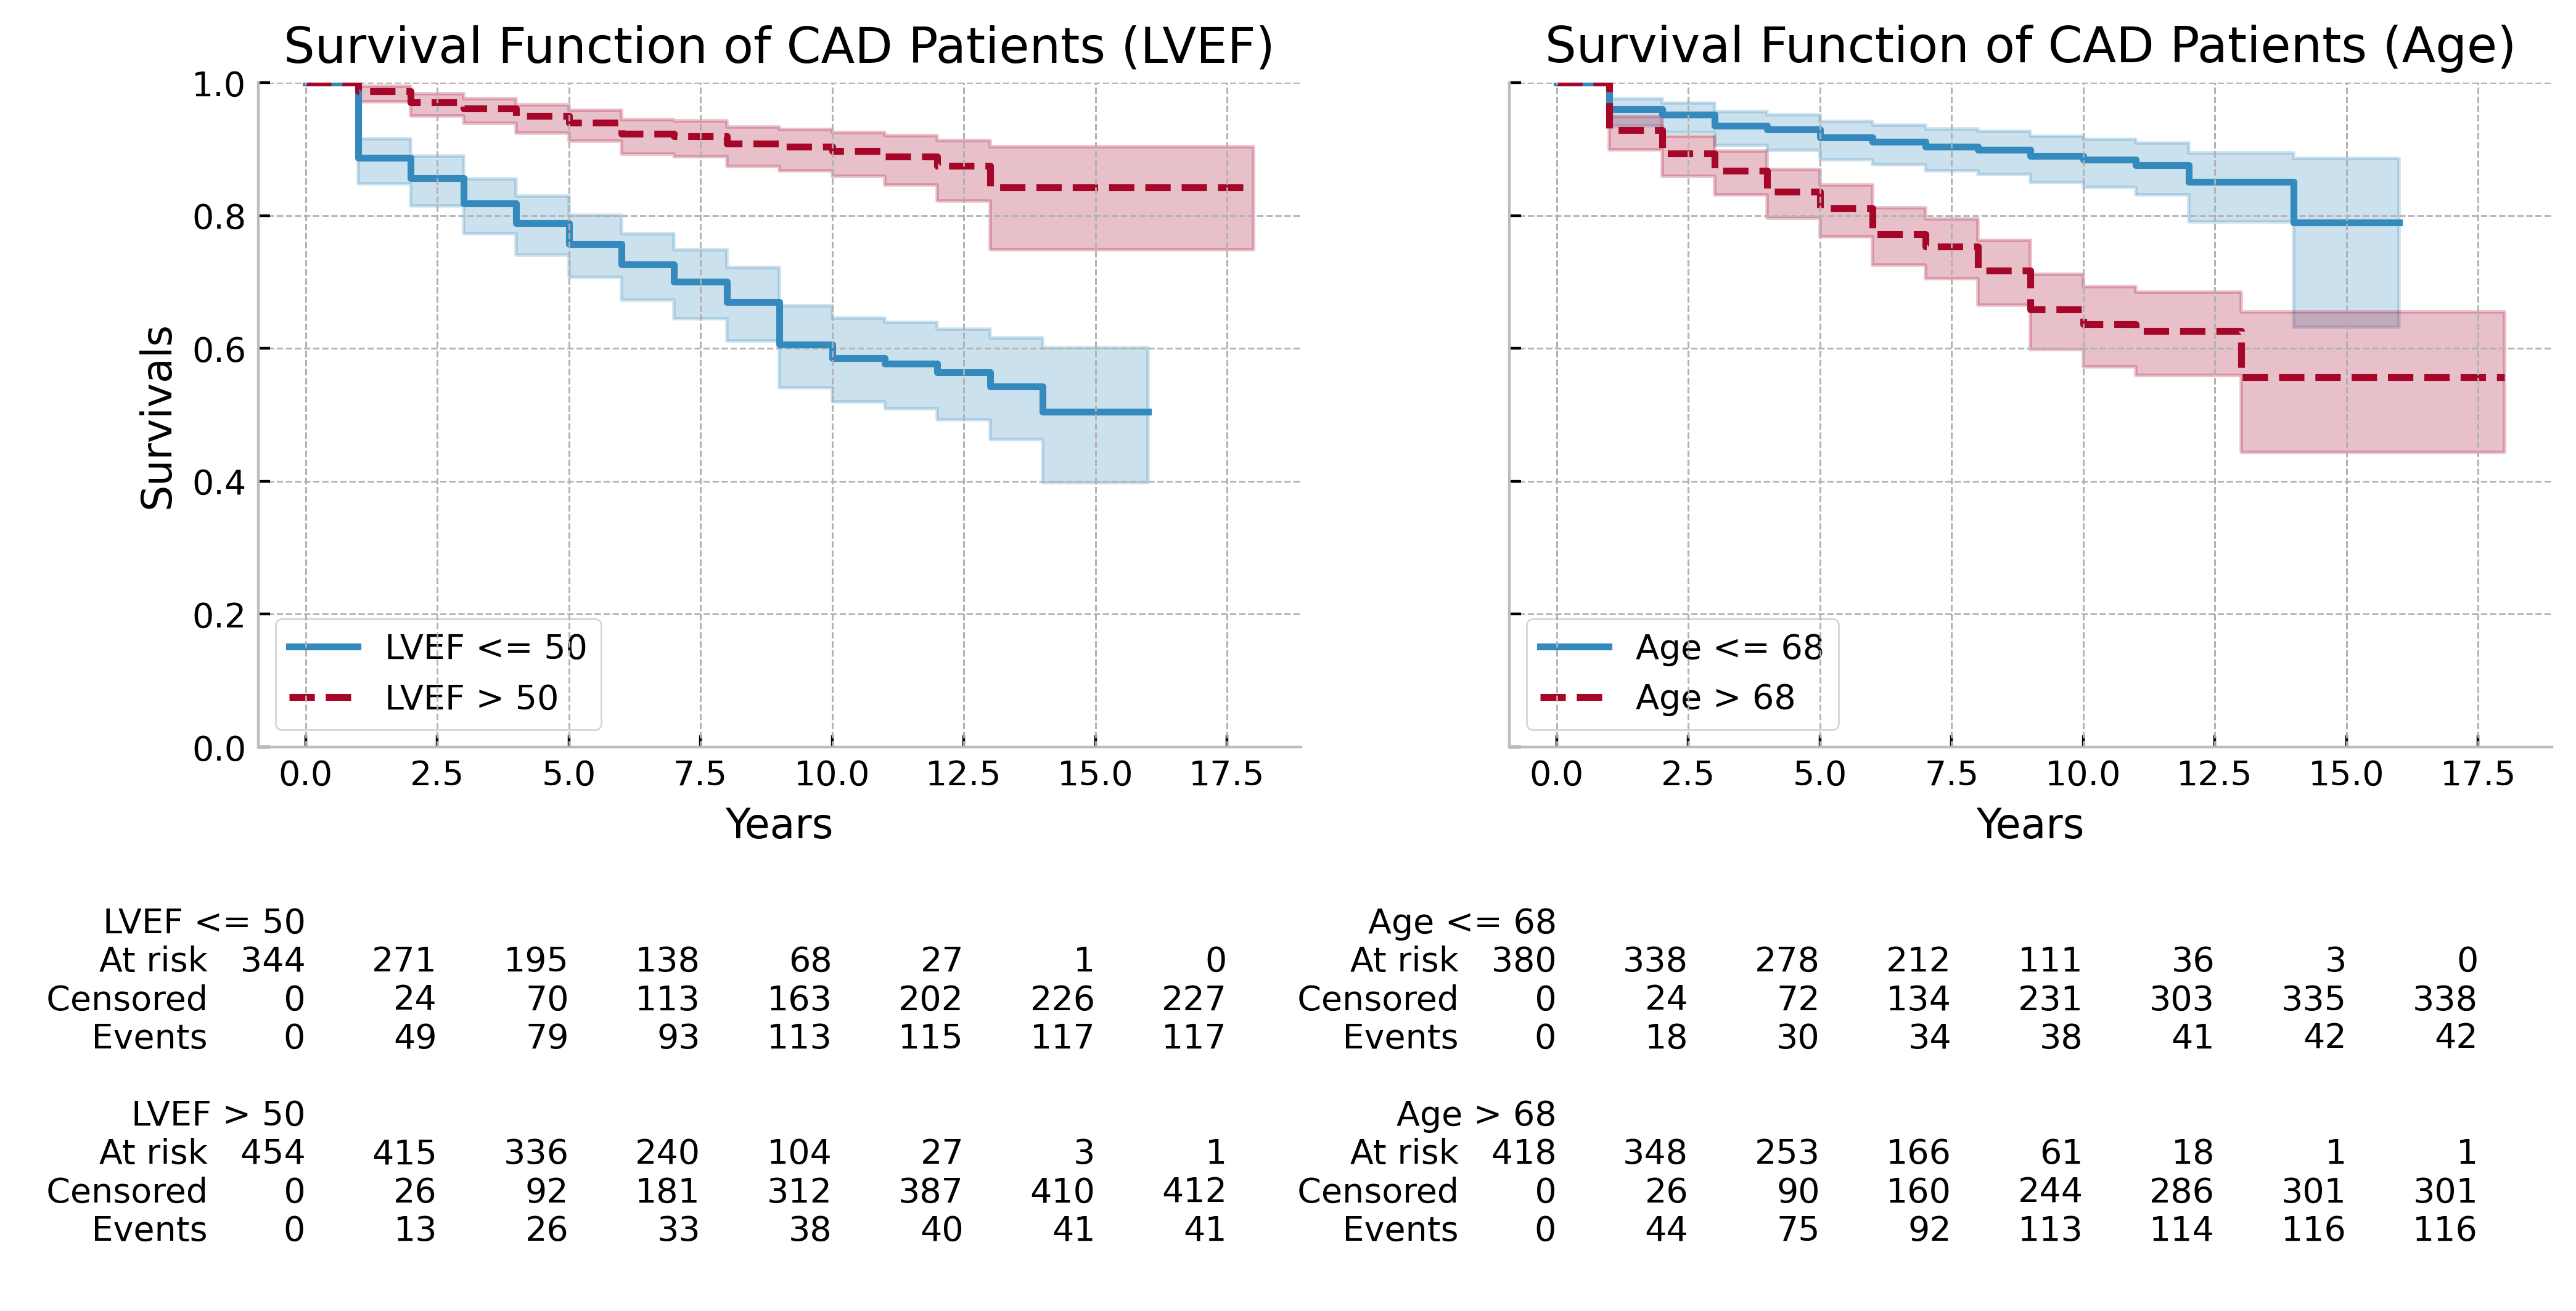

In [6]:
fig = plt.figure(figsize=(12, 3.5), dpi=400) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.10, wspace=0.20)

# Dyslipidemia
plt.subplot2grid(fig_dims, (0, 0))
mean = df_test["FE"].mean()
df_under_mean = df_test[df_test["FE"] <= mean]
df_above_mean = df_test[df_test["FE"] > mean]

kmf1 = KaplanMeierFitter()
kmf1.fit(df_under_mean["duration"], event_observed=df_under_mean["observed"], label=f"LVEF <= {int(mean)}")
kmf1.plot_survival_function()
kmf2 = KaplanMeierFitter()
kmf2.fit(df_above_mean["duration"], event_observed=df_above_mean["observed"], label=f"LVEF > {int(mean)}")
kmf2.plot_survival_function(linestyle="--")

plt.title('Survival Function of CAD Patients (LVEF)')
plt.xlabel("Years")
plt.ylabel("Survivals")
plt.ylim(0, 1)
plt.legend(loc="lower left")
plotting.add_at_risk_counts(kmf1, kmf2)

# FE
plt.subplot2grid(fig_dims, (0, 1))
mean = df_test["Age"].mean()
df_under_mean = df_test[df_test["Age"] <= mean]
df_above_mean = df_test[df_test["Age"] > mean]

kmf1 = KaplanMeierFitter()
kmf1.fit(df_under_mean["duration"], event_observed=df_under_mean["observed"], label=f"Age <= {int(mean)}")
kmf1.plot_survival_function()
kmf2 = KaplanMeierFitter()
kmf2.fit(df_above_mean["duration"], event_observed=df_above_mean["observed"], label=f"Age > {int(mean)}")
kmf2.plot_survival_function(linestyle="--")

plt.title('Survival Function of CAD Patients (Age)')
plt.xlabel("Years")
# plt.ylabel("Survivals")
plt.tick_params(labelleft=False)
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1, kmf2)

### Survival Analysis Model 

In [7]:
def plot_kmf(df_pred, threshold, variable):
    df_pred_under = df_pred[df_pred["ModelOutput"] <= threshold]
    df_pred_above = df_pred[df_pred["ModelOutput"] > threshold]

    kmf1 = KaplanMeierFitter()
    kmf1.fit(df_pred_under["duration"], event_observed=df_pred_under["observed"], label=f"<= {threshold}")
    kmf1.plot_survival_function()
    print(kmf1.survival_function_)

    kmf2 = KaplanMeierFitter()
    kmf2.fit(df_pred_above["duration"], event_observed=df_pred_above["observed"], label=f"> {threshold}")
    kmf2.plot_survival_function(linestyle="--")
    print(kmf2.survival_function_)

    plt.title(f'Survival Function of IHD Patients ({variable})')
    plt.xlabel("Years")
    plt.ylabel("Survivals")

    if threshold == 0.7:
        plt.ylabel("")
        plt.tick_params(labelleft=False)

    plt.ylim(0, 1)
    plotting.add_at_risk_counts(kmf1, kmf2)

In [8]:
df_out = pd.read_csv("./data/results/extra_test_output.csv", index_col=0, decimal='.')
df_out7 = pd.read_csv("./data/results/extra_test_output_top.csv", index_col=0, decimal='.')

# Model 18 features
df_test_pred = df_surv.drop(list(set(df_surv.index) - set(df_out.index)))
df_test_pred = df_test_pred.merge(df_out, how="left", left_index=True, right_index=True)

# Model 7 features
df_test7_pred = df_surv.drop(list(set(df_surv.index) - set(df_out7.index)))
df_test7_pred = df_test7_pred.merge(df_out7, how="left", left_index=True, right_index=True)

            <= 0.6
timeline          
0.0       1.000000
1.0       0.858209
2.0       0.807265
3.0       0.758340
4.0       0.716673
5.0       0.671881
6.0       0.631467
7.0       0.600813
8.0       0.545475
9.0       0.464995
10.0      0.454427
11.0      0.439768
12.0      0.419779
13.0      0.349816
14.0      0.291513
15.0      0.291513
16.0      0.291513
             > 0.6
timeline          
0.0       1.000000
1.0       0.986792
2.0       0.978882
3.0       0.970859
4.0       0.962648
5.0       0.956115
6.0       0.941701
7.0       0.936350
8.0       0.930149
9.0       0.918760
10.0      0.904839
11.0      0.898422
12.0      0.888095
13.0      0.888095
14.0      0.888095
15.0      0.888095
16.0      0.888095
18.0      0.888095
            <= 0.6
timeline          
0.0       1.000000
1.0       0.878205
2.0       0.838287
3.0       0.793624
4.0       0.768486
5.0       0.734912
6.0       0.694083
7.0       0.666685
8.0       0.635434
9.0       0.576048
10.0      0.569190
11.0      0.

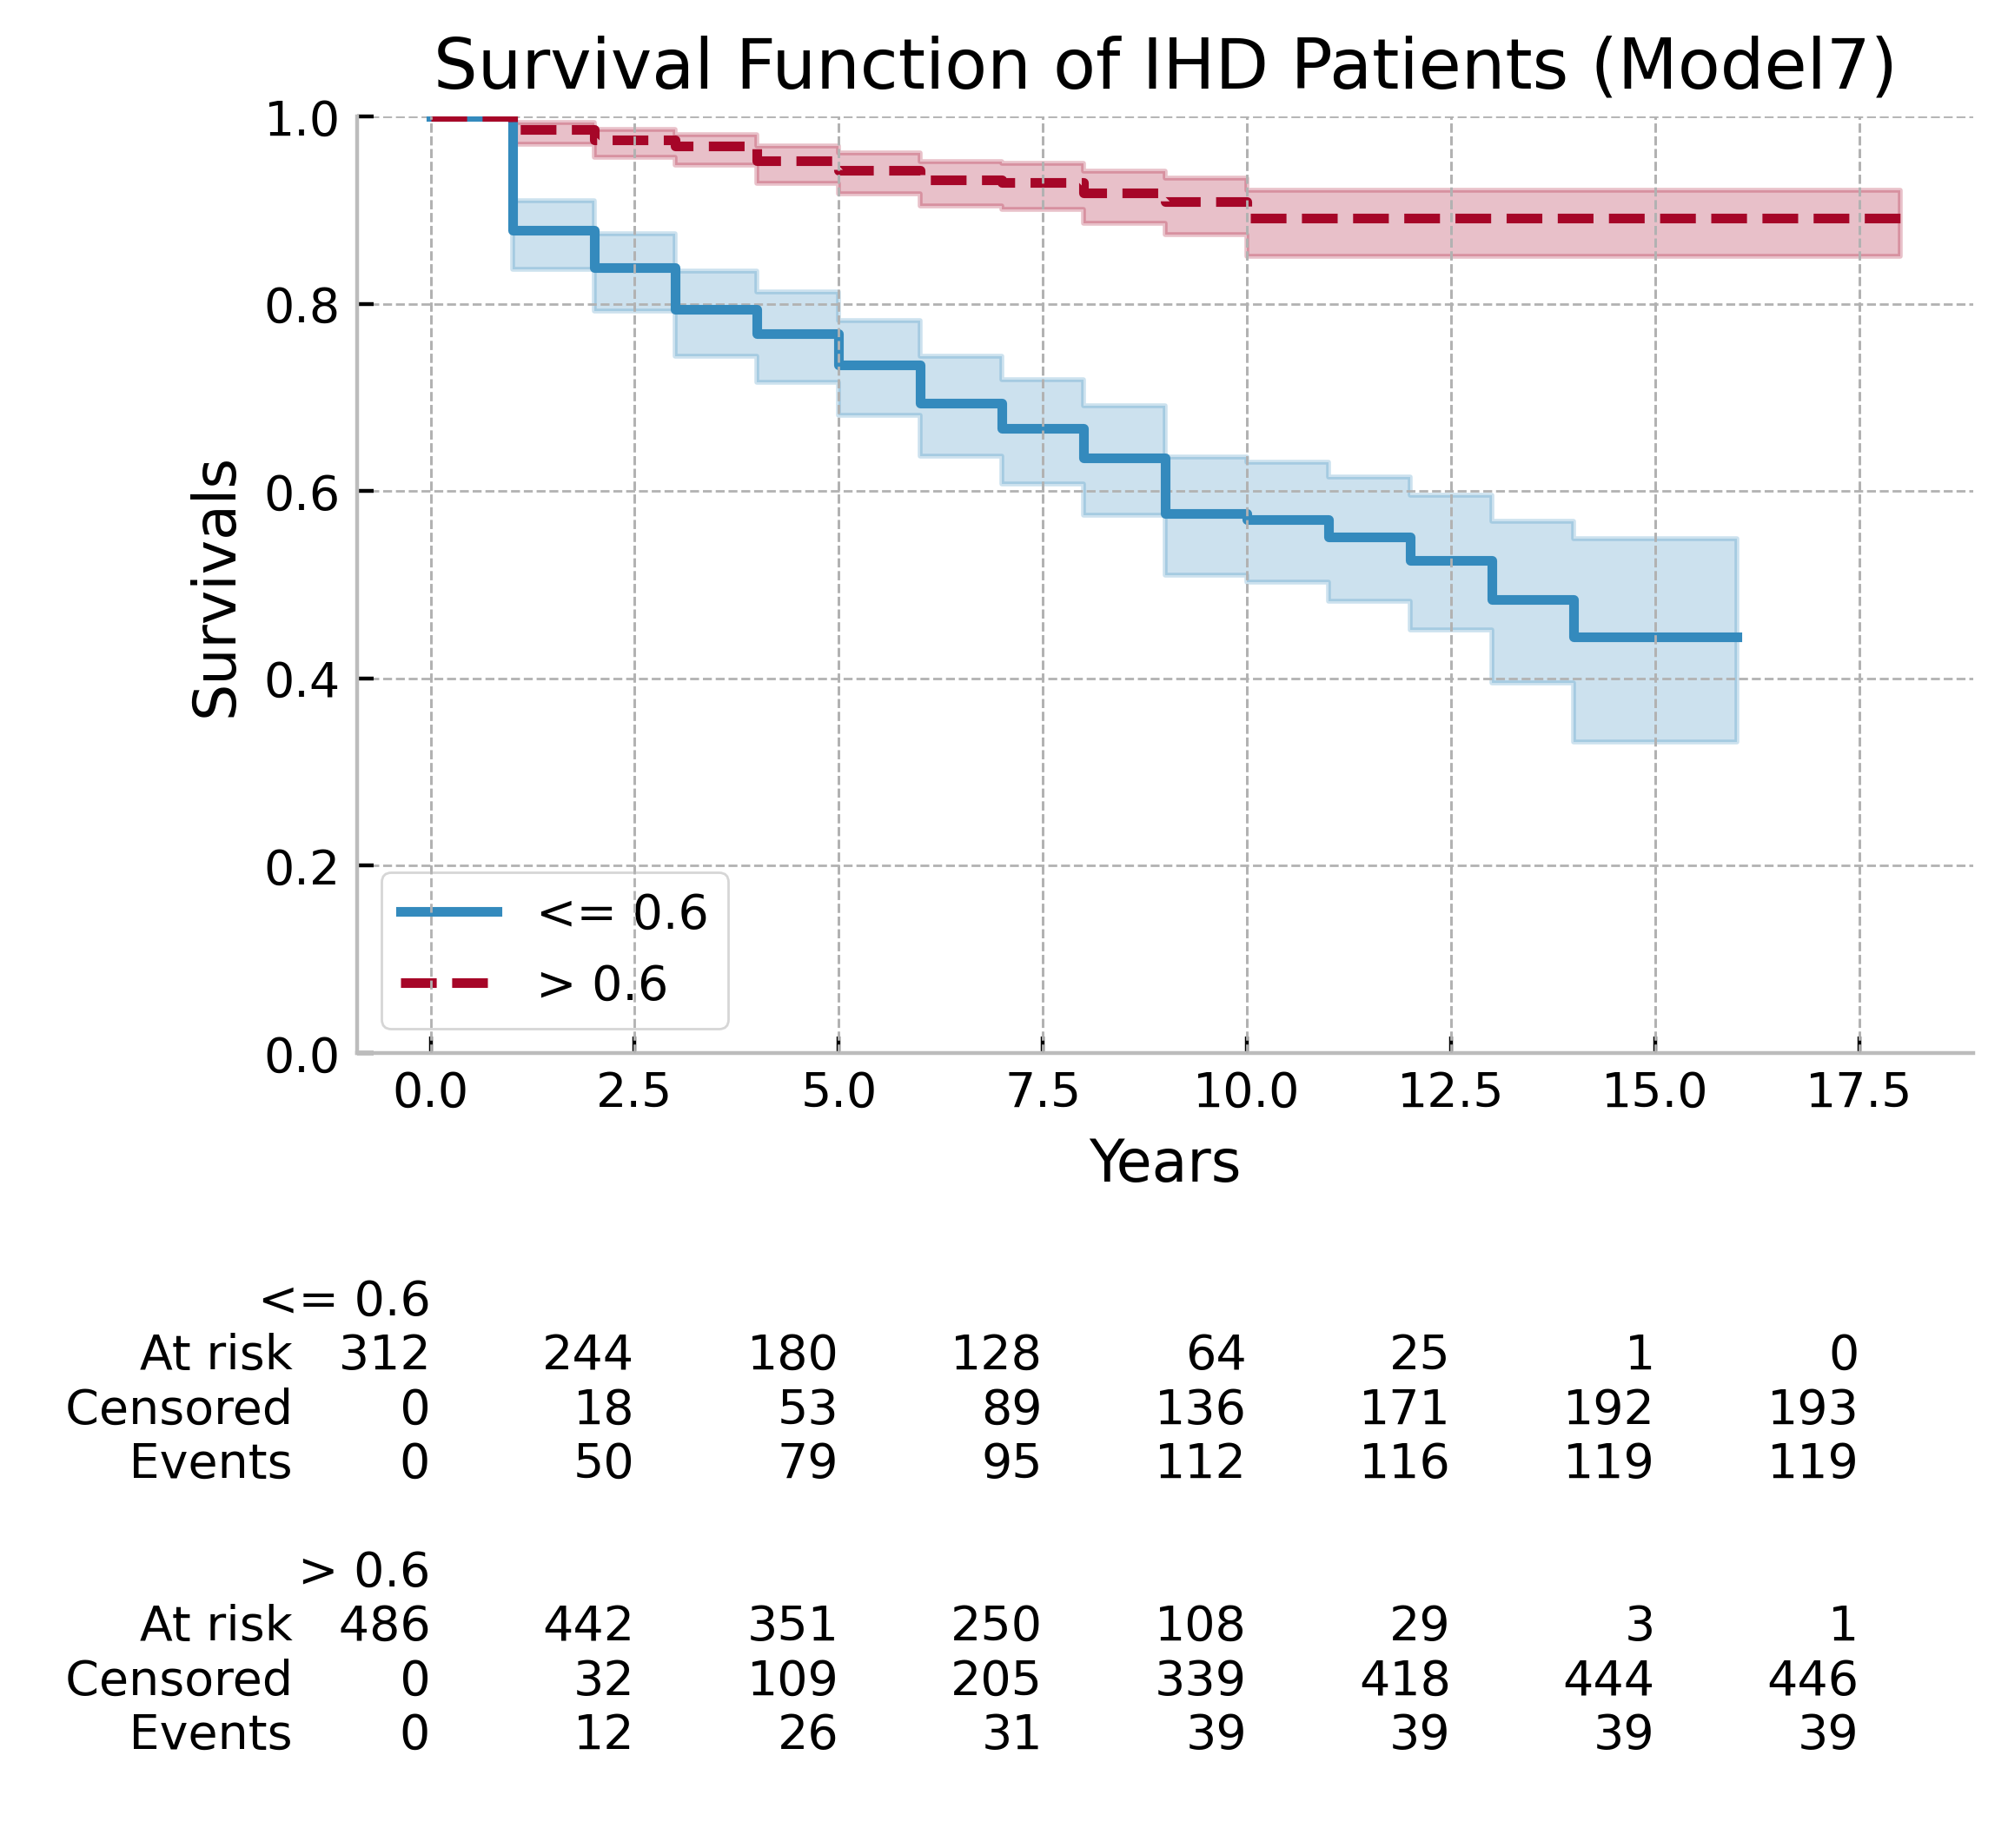

In [9]:
# Plots
fig = plt.figure(figsize=(6, 3.5), dpi=400) 
fig_dims = (1, 1)
fig.subplots_adjust(hspace=1, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plot_kmf(df_test_pred, threshold=0.6, variable="Model18")
plt.savefig("./figures/survival_model_18.tiff", format="tiff", bbox_inches="tight", dpi=400)

plt.subplot2grid(fig_dims, (0, 0))
plot_kmf(df_test7_pred, threshold=0.6, variable="Model7")
plt.savefig("./figures/survival_model_7.tiff", format="tiff", bbox_inches="tight", dpi=400)

### COX Regression and p-value 

In [10]:
df_out = pd.read_csv("./data/results/extra_test_output.csv", index_col=0, decimal='.')
df_out7 = pd.read_csv("./data/results/extra_test_output_top.csv", index_col=0, decimal='.')

# Model 18 all features
df_test_pred = df_surv.drop(list(set(df_surv.index) - set(df_out.index)))
df_test_pred = df_test_pred.merge(df_out, how="left", left_index=True, right_index=True)

# Model 7 top features
df_test7_pred = df_surv.drop(list(set(df_surv.index) - set(df_out7.index)))
df_test7_pred = df_test7_pred.merge(df_out7, how="left", left_index=True, right_index=True)

top = [
    "Hyperlipemia\nHistoty of hyperlipemia",
    "FE",
    "Previous CABG",
    "Diabetes\nHistory of diabetes",
    "Previous Myocardial Infarction",
    "Smoke\nHistory of smoke",
    "Documented resting \nor exertional ischemia",
]

Univariate

In [11]:
i = 17
cph = CoxPHFitter()
cph.fit(df_test_pred.loc[:, [df_test_pred.columns[i], "duration", "observed"]], duration_col='duration', event_col='observed')
cph.fit(df_test_pred.loc[:, ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
# cph.fit(df_test7_pred.loc[:, ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
# cph.print_summary()
print(df_test_pred.columns[i])
cph.concordance_index_

Creatinina


0.8179901310784079

Multivariate Top 7 variables

In [12]:
cph = CoxPHFitter()
cph.fit(df_test_pred.loc[:, top + ["duration", "observed"]], duration_col='duration', event_col='observed')
cph.print_summary()

/opt/anaconda3/envs/py385/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 798 total observations, 640 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 798
number of events observed = 158
   partial log-likelihood = -906.41
         time fit was run = 2024-03-25 15:25:42 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
Hyperlipemia\nHistoty of hyperlipemia        -0.96       0.38       0.17            -1.29            -0.62                 0.27                 0.54
FE                                           -0.06       0.94       0.01            -0.08            -0.05                 0.92                 0.95
Previous CABG                                 0.47       1.60       0.19             0.09             0.84                 1.10                 2.32
Diabetes\nHistory of diabetes                 0.46       1.59       0.17             0.12             0.80                 1.13                 2.22
Previous Myocardial Infarction                0.02       1.02       0.18            -0.33             0.38                 0.72                 1.46
Smoke\nHistory of smoke                      -0.33       0.72       0.17            -0.66            -0.01                 0.52                 0.99
Documented resting \nor exertional ischemia   0.05       1.05       0.18            -0.31             0.40                 0.73                 1.50

                                              cmp to     z      p   -log2(p)
covariate                                                                   
Hyperlipemia\nHistoty of hyperlipemia           0.00 -5.55 <0.005      25.04
FE                                              0.00 -9.04 <0.005      62.48
Previous CABG                                   0.00  2.46   0.01       6.16
Diabetes\nHistory of diabetes                   0.00  2.69   0.01       7.12
Previous Myocardial Infarction                  0.00  0.13   0.90       0.15
Smoke\nHistory of smoke                         0.00 -2.02   0.04       4.54
Documented resting \nor exertional ischemia     0.00  0.25   0.80       0.32
---
Concordance = 0.78
Partial AIC = 1826.82
log-likelihood ratio test = 175.03 on 7 df
-log2(p) of ll-ratio test = 111.82

Multivariate Top 7 variables + Model 7

In [13]:
cph = CoxPHFitter()
cph.fit(df_test7_pred.loc[:, top + ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
cph.print_summary()

/opt/anaconda3/envs/py385/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 798 total observations, 640 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 798
number of events observed = 158
   partial log-likelihood = -905.35
         time fit was run = 2024-03-25 15:25:59 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
Hyperlipemia\nHistoty of hyperlipemia        -0.71       0.49       0.24            -1.18            -0.24                 0.31                 0.78
FE                                           -0.04       0.96       0.02            -0.08            -0.01                 0.93                 0.99
Previous CABG                                 0.39       1.47       0.20            -0.00             0.77                 1.00                 2.17
Diabetes\nHistory of diabetes                 0.40       1.49       0.18             0.05             0.74                 1.05                 2.10
Previous Myocardial Infarction               -0.04       0.96       0.19            -0.41             0.32                 0.66                 1.38
Smoke\nHistory of smoke                      -0.14       0.87       0.21            -0.56             0.28                 0.57                 1.32
Documented resting \nor exertional ischemia   0.11       1.12       0.19            -0.26             0.48                 0.77                 1.62
ModelOutput                                  -2.14       0.12       1.46            -4.99             0.72                 0.01                 2.05

                                              cmp to     z      p   -log2(p)
covariate                                                                   
Hyperlipemia\nHistoty of hyperlipemia           0.00 -2.99 <0.005       8.48
FE                                              0.00 -2.49   0.01       6.30
Previous CABG                                   0.00  1.95   0.05       4.28
Diabetes\nHistory of diabetes                   0.00  2.24   0.03       5.31
Previous Myocardial Infarction                  0.00 -0.24   0.81       0.30
Smoke\nHistory of smoke                         0.00 -0.65   0.52       0.95
Documented resting \nor exertional ischemia     0.00  0.61   0.54       0.88
ModelOutput                                     0.00 -1.47   0.14       2.81
---
Concordance = 0.78
Partial AIC = 1826.69
log-likelihood ratio test = 177.16 on 8 df
-log2(p) of ll-ratio test = 110.92

Multivariate Top 7 variables + Model 18

In [14]:
cph = CoxPHFitter()
cph.fit(df_test_pred.loc[:, top + ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
cph.print_summary()

/opt/anaconda3/envs/py385/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 798 total observations, 640 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 798
number of events observed = 158
   partial log-likelihood = -874.87
         time fit was run = 2024-03-25 15:26:03 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
Hyperlipemia\nHistoty of hyperlipemia        -0.13       0.88       0.20            -0.52             0.27                 0.59                 1.31
FE                                           -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
Previous CABG                                 0.05       1.06       0.20            -0.34             0.44                 0.71                 1.56
Diabetes\nHistory of diabetes                 0.30       1.35       0.17            -0.04             0.64                 0.96                 1.89
Previous Myocardial Infarction               -0.24       0.79       0.19            -0.60             0.13                 0.55                 1.14
Smoke\nHistory of smoke                       0.15       1.16       0.17            -0.19             0.49                 0.83                 1.64
Documented resting \nor exertional ischemia   0.09       1.10       0.18            -0.26             0.44                 0.77                 1.56
ModelOutput                                  -6.76       0.00       0.85            -8.43            -5.09                 0.00                 0.01

                                              cmp to     z      p   -log2(p)
covariate                                                                   
Hyperlipemia\nHistoty of hyperlipemia           0.00 -0.62   0.54       0.90
FE                                              0.00 -0.92   0.36       1.48
Previous CABG                                   0.00  0.27   0.79       0.35
Diabetes\nHistory of diabetes                   0.00  1.74   0.08       3.61
Previous Myocardial Infarction                  0.00 -1.27   0.20       2.30
Smoke\nHistory of smoke                         0.00  0.87   0.38       1.38
Documented resting \nor exertional ischemia     0.00  0.51   0.61       0.71
ModelOutput                                     0.00 -7.92 <0.005      48.59
---
Concordance = 0.82
Partial AIC = 1765.73
log-likelihood ratio test = 238.12 on 8 df
-log2(p) of ll-ratio test = 153.63

Multivariate all variables

In [15]:
df_feat = df_test_pred.drop(columns=["Survive7Y", "Death7Y", "ID", "ModelOutput"])

cph = CoxPHFitter()
cph.fit(df_feat, duration_col='duration', event_col='observed')
cph.print_summary()
cph.concordance_index_

/opt/anaconda3/envs/py385/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 798 total observations, 640 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 798
number of events observed = 158
   partial log-likelihood = -870.83
         time fit was run = 2024-03-25 15:26:06 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
Gender (Male = 1)                            -0.51       0.60       0.20            -0.89            -0.13                 0.41                 0.88
Age                                           0.05       1.05       0.01             0.03             0.07                 1.03                 1.07
Angina                                        0.46       1.59       0.21             0.05             0.87                 1.05                 2.40
Previous CABG                                 0.06       1.07       0.24            -0.40             0.53                 0.67                 1.70
Previous PCI                                  0.02       1.02       0.22            -0.40             0.44                 0.67                 1.56
Previous Myocardial Infarction                0.07       1.07       0.19            -0.31             0.45                 0.74                 1.57
Acute Myocardial Infarction                   0.17       1.19       0.22            -0.27             0.61                 0.77                 1.83
Angiography                                  -0.46       0.63       0.27            -0.99             0.08                 0.37                 1.08
Vessels                                       0.22       1.24       0.08             0.06             0.38                 1.06                 1.46
FE                                           -0.07       0.93       0.01            -0.09            -0.06                 0.91                 0.95
Documented resting \nor exertional ischemia  -0.14       0.87       0.20            -0.54             0.25                 0.58                 1.29
Post-ischemic Dilated\nCardiomyopathy        -0.38       0.68       0.26            -0.89             0.13                 0.41                 1.14
Smoke\nHistory of smoke                       0.14       1.15       0.19            -0.23             0.51                 0.79                 1.66
Diabetes\nHistory of diabetes                 0.51       1.66       0.18             0.16             0.86                 1.17                 2.36
Hypertension\nHistory of hypertension         0.11       1.12       0.19            -0.26             0.48                 0.77                 1.62
Hyperlipemia\nHistoty of hyperlipemia        -0.91       0.40       0.18            -1.27            -0.56                 0.28                 0.57
Paroxysmal or chronic \natrial fibrillation   0.36       1.43       0.22            -0.07             0.79                 0.93                 2.20
Creatinina                                    0.18       1.20       0.06             0.05             0.30                 1.06                 1.35

                                              cmp to     z      p   -log2(p)
covariate                                                                   
Gender (Male = 1)                               0.00 -2.62   0.01       6.81
Age                                             0.00  4.89 <0.005      19.89
Angina                                          0.00  2.20   0.03       5.17
Previous CABG                                   0.00  0.27   0.79       0.35
Previous PCI                                    0.00  0.10   0.92       0.12
Previous Myocardial Infarction                  0.00  0.37   0.71       0.49
Acute Myocardial Infarction            

0.8235115101189053